In [143]:
import pandas as pd
import datetime
import numpy as np 
import pandas_datareader.data as web
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix 
from math import ceil 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR


In [144]:
#Loading Yahoo Finance dataset
start = datetime.datetime(2009,1,1)
end = datetime.datetime(2019, 9, 1)

df = web.DataReader("AAPL", "yahoo", start, end)
df.tail()



,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-26,207.190002,205.059998,205.860001,206.490005,26043600.0,206.490005
2019-08-27,208.550003,203.529999,207.860001,204.160004,25873300.0,204.160004
2019-08-28,205.720001,203.320007,204.100006,205.529999,15938800.0,205.529999
2019-08-29,209.320007,206.660004,208.500000,209.009995,20990500.0,209.009995
2019-08-30,210.449997,207.199997,210.160004,208.740005,21143400.0,208.740005


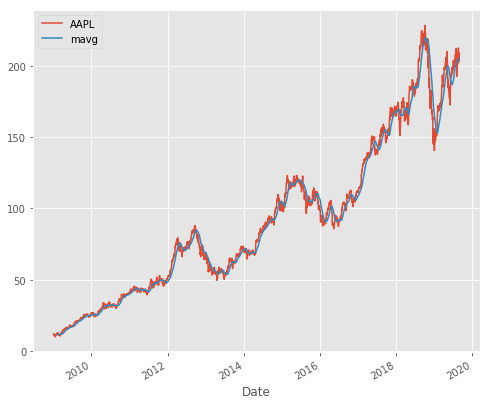

In [145]:
#Find the rolling mean of the stock
close_px = df['Adj Close']
mavg = close_px.rolling(window=30).mean()

#to better understand rolling mean, let's plot it on matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style

#adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

#Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()




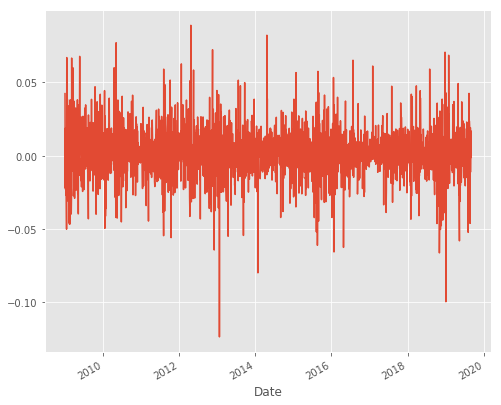

In [146]:
#plot the returns of the stock
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')




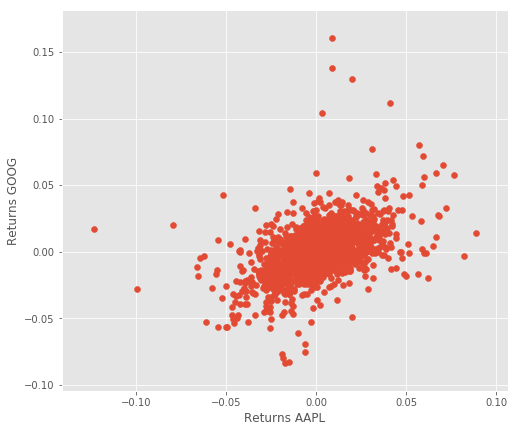

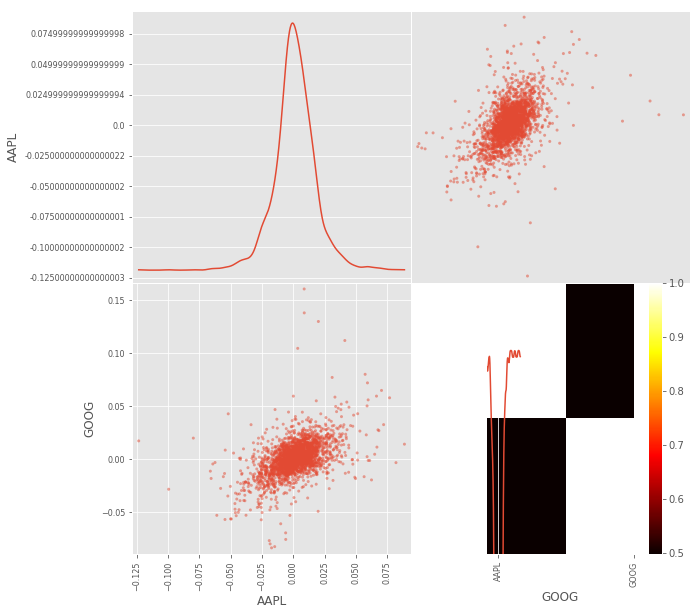

In [147]:
#analyzing competitor stocks as well
dfcomp = web.DataReader(['AAPL', 'GOOG'], 'yahoo', start=start, end=end)['Adj Close']

# run a correlation function to see if any of the stocks are correlated
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

#plotting competitors to see their return distributions
plt.scatter(retscomp.AAPL, retscomp.GOOG)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GOOG')


#using Kernel Density Estimate to smooth data and visualize possible correlations
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

#create a heatmap to prove the positive correlations
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);



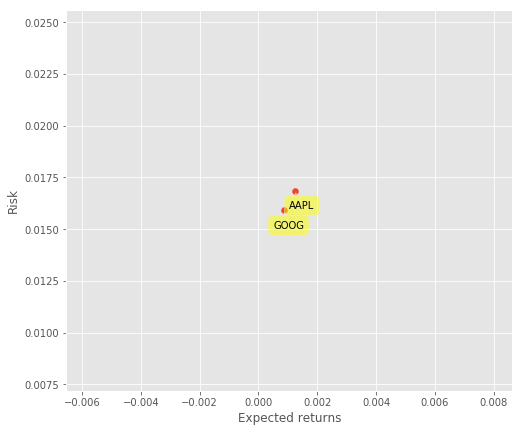

In [148]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [149]:

dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.tail()


,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-08-26,206.490005,26043600.0,1.031529,0.306036
2019-08-27,204.160004,25873300.0,2.458858,-1.780043
2019-08-28,205.529999,15938800.0,1.167710,0.700633
2019-08-29,209.009995,20990500.0,1.272668,0.244602
2019-08-30,208.740005,21143400.0,1.556961,-0.675675


In [150]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
dfreg.dropna(inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=999)

In [151]:
#Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

#Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

#Quadratic Regression 3
clfsvr = SVR(kernel='linear', C=100, gamma='auto')
clfsvr.fit(X_train, y_train)

#KNN regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

#let's evaluate all of the models against eachother
confidencereg = clfreg.score(X_test,y_test)
confidencepoly2 = clfpoly2.score(X_test, y_test)
confidencesvr = clfsvr.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

# results
('The linear regression confidence is', confidencereg)
('The quadratic regression 2 confidence is ', confidencepoly2)
('The support vector regression confidence is ', confidencesvr)
('The knn regression confidence is ', confidenceknn)

#printing some of the stocks forecasts
forecast_set_reg = clfreg.predict(X_lately)
forecast_set_poly2 = clfpoly2.predict(X_lately) 
forecast_set_svr = clfsvr.predict(X_lately)
forecast_set_knn = clfknn.predict(X_lately) 
dfreg['Forecast'] = np.nan
dfpoly2 = dfreg
dfsvr = dfreg
dfknn = dfreg

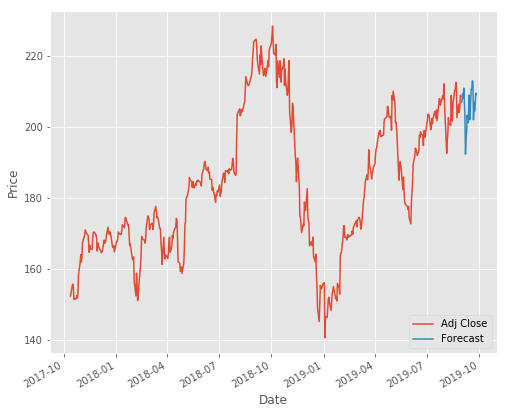

In [152]:
#Plotting the forecast with existing historical data so we can compare it to future price movements
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_reg:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

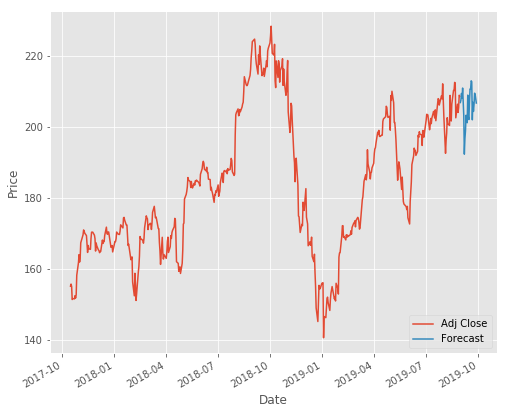

In [153]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_poly2:
    next_date = next_unix
    next_date += datetime.timedelta(days=1)
    dfpoly2.loc[next_date] = [np.nan for _ in range(len(dfpoly2.columns)-1)]+[i]
dfpoly2['Adj Close'].tail(500).plot()
dfpoly2['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

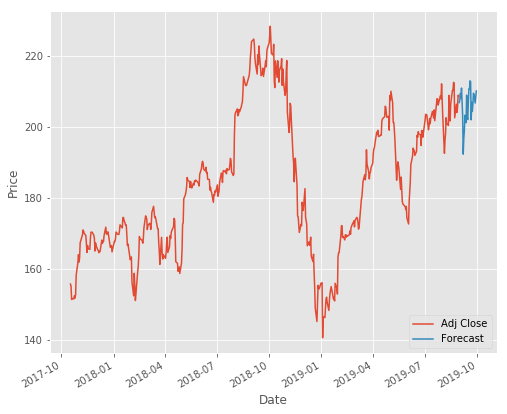

In [154]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_svr:
    next_date = next_unix
    next_date += datetime.timedelta(days=1)
    dfsvr.loc[next_date] = [np.nan for _ in range(len(dfsvr.columns)-1)]+[i]
dfsvr['Adj Close'].tail(500).plot()
dfsvr['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

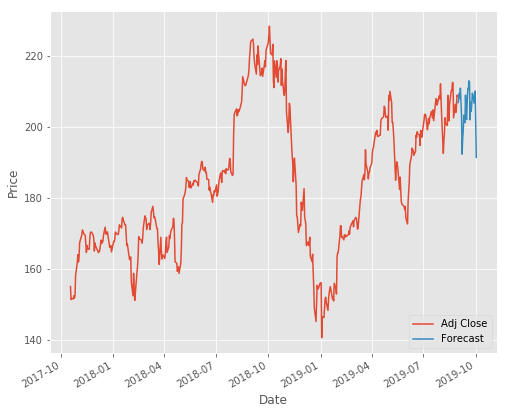

In [155]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_knn:
    next_date = next_unix
    next_date += datetime.timedelta(days=1)
    dfknn.loc[next_date] = [np.nan for _ in range(len(dfknn.columns)-1)]+[i]
dfknn['Adj Close'].tail(500).plot()
dfknn['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()